# Primerjava pristopov za specifične besede

V tej skripti primerjamo pristope za izbor specifičnih (ključnih) besed v vsakem besedilu.

In [26]:
import string
from collections import Counter

import nltk
import pandas as pd
import seaborn as sns
from textsemantics.server_api import ServerAPI
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from lemmagen.lemmatizer import Lemmatizer
from lemmagen import DICTIONARY_SLOVENE
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import display, Markdown

from utils.specific_words import prepare_data, find_corpus_words, find_document_words
from utils.word_enrichment import hypergeom_p_values, FDR

Naloži metapodatke, vse dokumente in jih predprocesiraj

In [3]:
nltk.download('stopwords', quiet=True)

def preprocess(corpus):
    stop_words = set(stopwords.words('slovene'))
    tokenizer = RegexpTokenizer("\w+")
    lemmatizer = Lemmatizer(dictionary=DICTIONARY_SLOVENE)
    
    preprocessed = list()
    for text in corpus:
        text = text.translate(text.maketrans('', '', string.punctuation))
        tokens = tokenizer.tokenize(text.lower())
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words 
                  and len(token) > 2 and not token.isnumeric()]
        preprocessed.append(tokens)
        
    return preprocessed

api = ServerAPI()
datasets = api.list_datasets()
metadata = api.get_metadata(datasets[2][0], sample_size=100, sampling_strategy='latest')

texts = api.get_texts(urls=metadata['text'])
metadata["texts"] = texts
data = metadata[metadata["texts"].str.len() > 50]

tokens_list = preprocess(data["texts"])

Upoabimo metodo za iskanje specifičnih besed s pomočjo embeddingov.

In [19]:
doc_embs, words, word_embs, word2doc, doc2word = prepare_data(tokens_list)
specific_emb1 = find_corpus_words(doc_embs, words, word_embs)
specific_emb2 = find_document_words(doc_embs, words, word_embs, word2doc, doc2word)

/Users/primoz/PycharmProjects/text-semantics/examples/utils/specific_words.py:39: RuntimeWarning: invalid value encountered in double_scalars
  return x.dot(y) / np.linalg.norm(x) / np.linalg.norm(y)


Upoabimo metodo za iskanje specifičnih besed s pomočjo word enrichment.

In [43]:
joined_texts = [' '.join(tokens) for tokens in tokens_list]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(joined_texts)
words = vectorizer.get_feature_names()

def specific_words_enrichment(document_index):
    p_values = hypergeom_p_values(X, X[document_index])
#     fdr = FDR(p_values)
    df = pd.DataFrame(
        {"Besede": words, "P-Vrednost": p_values}
    ).sort_values("P-Vrednost", axis=0)
    return df["Besede"].values

specific_enrichment = [specific_words_enrichment(i) for i in range(len(data['texts']))]

Upoabimo metodo za iskanje specifičnih besed s pomočjo TF-IDF.

In [13]:
def find_tfidf_words(document_id):
    feature_index = X[document_id,:].nonzero()[1]
    features = [(words[i], X[document_id, i]) for i in feature_index]
    words_score = sorted(features, key=lambda tup: tup[1], reverse=True)
    return [w for w, s in words_score]

specific_tfidf = [find_tfidf_words(i) for i in range(len(data['texts']))]

## Grafična primerjava specifičnih besed

Specifične besede izbrane štirimi raličnimi pristopi bomo najprej primerjali grafično. Pripravimo metodo, ki izpiše besedilo in specifične besede, nato pa še izriše graf, ki prikazuje prisotnost posamezne besede pri vsaki od metod. Rezultate pokažemo na štirih besedilih.

In [33]:
def plot_specific_words(document_id):
    num_words = 15
    md = f"### {data.iloc[document_id].loc['title']}\n{data.iloc[document_id].loc['texts']}\n"

    method_names = ["Emb 1", "Emb 2", "W. enrichment", "TF-IDF"]
    sp_words = [specific_emb1, specific_emb2, specific_enrichment, specific_tfidf]
    spec_words = [method[document_id][:num_words] for method in sp_words]

    # join specific words for method
    for method, sp_words in zip(method_names, spec_words):
        md += f"- **{method}**: {', '.join(sp_words)}\n"
    display(Markdown(md))

    # heatmap
    all_words = [c for c, _ in Counter([y for x in spec_words for y in x]).most_common()]
    belongs = [[word in m for m in spec_words] for word in all_words]
    sns.heatmap(pd.DataFrame(belongs, columns=method_names, index=all_words), cmap='Blues')

### Videvanja z partnerjem z tujine med epidemijo.
Predlagam, da se kot izjema za prehajanje regije, občine ali državne meje, uvede tudi vzdrževanje stikov z partnerji iz tujine. Sam, kot tudi drugi smo namreč zaradi tega prizadeti, saj nas veliko živi ob meji s Hrvaško na primer, 15 min vožnje stran eden od drugega, a zaradi restriktivnih srečanje ni možno, čez Kolpo si pa lahko mahamo. Je bil 1. Val dovolj, da se nisem mogel videti s punco, katere tudi skoraj nisem prepoznal, po 2 mesecih razdvojenosti. Lp
- **Emb 1**: meja, kolpa, regija, val, preža, migracija, tujina, vrana, povezava, vran, ina, punca, sosednji, okolica, stran
- **Emb 2**: predlagati, lahek, velik, dovolj, sam, meja, videti, prepoznati, razdvojenost, prehajanje, punca, primer, tujina, kolpa, možen
- **W. enrichment**: vzdrževanje, punca, razdvojenost, partner, regija, mahati, mina, restriktiven, kolpa, živ, hrvaški, prehajanje, tujina, prepoznati, srečanje
- **TF-IDF**: meja, kolpa, mahati, mina, partner, punca, razdvojenost, regija, restriktiven, vzdrževanje, hrvaški, prehajanje, tujina, živ, prepoznati


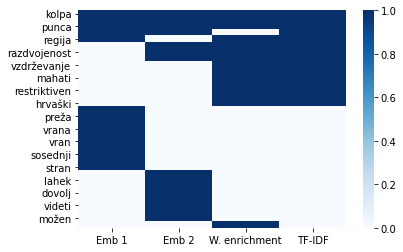

In [34]:
plot_specific_words(13)

Besede so razvrščene glede na pogostost identifikacije s strani pristopov.

### Letos učenci naj ne bodo ocenjeni
Zaradi ponovnega dela na daljavo bo znanje učencev slabo, hkrati bo pomanjkanje ocen oziroma bodo te verjetno (tako, kot lansko leto) bolj domišljijske, kot realne. Predlagam, da se za letošnje leto zgolj ugotovi, ali je učenec letnik OPRAVIL, OPRAVIL S POHVALO ali pa NI OPRAVIL. Za prehod na naslednji nivo šolanja (torej iz osnovne na srednjo ter srednje na visoko šolo) pa naj se končno ponovno uvede sprejemne izpite. Vsaka šola zase najbolje ve, katera znanja in sposobnosti želi pri svojih dijakih oziroma študentih. Prav tako je vsem jasno, da zbiranje točk za vpis s seštevanjem ocen, ki so ali niso realne/izsiljene/podarjene ni pošteno niti smiselno.
- **Emb 1**: šolanje, dijak, izpit, srednji, učenec, znanje, srednješolec, učen, šolski, poučevanje, učitelj, študij, letošnji, ocenjevanje, učenje
- **Emb 2**: predlagati, osnoven, šolanje, znanje, dijak, izpit, realen, smiseln, ponoven, šola, letošnji, vpis, slab, opravilo, končen
- **W. enrichment**: seštevanje, sposobnost, pohvala, opravilo, pomanjkanje, ocena, domišljijski, realneizsiljenepodarjen, vpis, ugotoviti, sprejemen, končen, letošnji, pošten, prehod
- **TF-IDF**: opravilo, ocena, učenec, znanje, ponoven, srednji, leto, šola, domišljijski, pohvala, pomanjkanje, realneizsiljenepodarjen, seštevanje, sposobnost, jasen


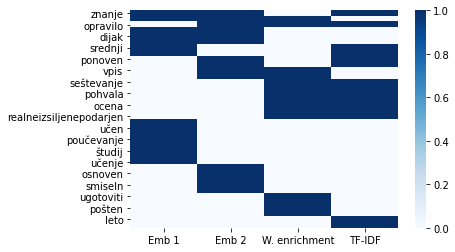

In [35]:
plot_specific_words(15)

### Finančna pomoč gorskim reševalcem 2
Ponovno dajem na glasovanje predlog v upanju, da bo sedaj zadosti podpore, da bi se ta predlog začel odvijat v pravo smer.
 
Predlagam, da bi ob posredovanjih gorske reševalne službe v primeru, da se pohodnik v hribih poškoduje in je bilo ob reševanju ugotovljeno, da ni imel ustrezne opreme za hojo v hribih denarno kaznuje pohodnika, kazen bi dodelil vodja reševanja in bi potem podal podatke za kazen naprej na policijo, in od te kazni bi se denar nameni gorski reševalni službi, ki je posredovala v tistem času, za primer recimo: reševanje brez helikopterja 100% gre denar v društvo, ob posredovanju z helikopterjem bi se ta kazen nekoliko razpolovila in bi nekaj denarja dobila enota HeNMP za stroške goriva nekaj pa gorska reševalna služba. Vemo, da je bil pred kakšnim letom na televiziji prispevek o gorski reševalni službi iz Kamnika kjer so zbirali sredstva za dostojen objekt v katerem bi imeli vso opremo za posredovanja in vozila. In menim, da bi s takim načinom lahko omogočili brezskrbno nadaljne posredovanje in ohranitev društev.
- **Emb 1**: reševanje, posredovanje, gorski, služba, helikopter, posredovati, priskočiti, usposabljanje, reševati, kazen, policija, vozilo, usposabljati, kazenski, pohodnik
- **Emb 2**: predlagati, imeti, posredovati, iti, omogočiti, kaznovati, lahek, vedeti, posredovanje, služba, podati, začeti, dobiti, policija, denar
- **W. enrichment**: kamnik, gorski, posredovanje, posredovati, dostojen, helikopter, henmp, glasovanje, podati, ugotovljen, reševalen, razpoloviti, poškodovati, pohodnik, brezskrben
- **TF-IDF**: gorski, posredovanje, reševalen, kazen, služba, reševanje, denar, helikopter, pohodnik, hrib, oprema, društvo, predlog, primer, brezskrben


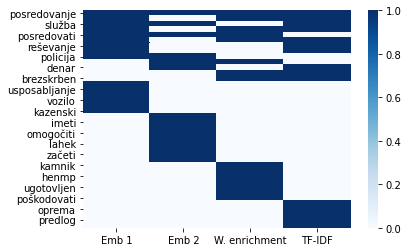

In [36]:
plot_specific_words(16)

In [51]:
pd.DataFrame(X.toarray(), columns=words).to_csv("tfidf.csv", index=False)

## Globalna primerjava - ideje

Pregledal sem več virov in večinoma primerjajo tako, da vzamejo ali besedila, ki imajo keyworde (članki) v enem primeru pa sem zasledil, da to naredijo brez predhodnih keywordov. V tem primeru vzamejo besedila, ki so klasificirana v več skupin in računajo kako dobri značilke so keywordi za klasifikacijo v te skupine z SVN in Information Gain. Jaz predlagama dve možnosti:
1. Najdemo besedila z obstoječimi keywordi in preizkusimo naše pristope na njih - besedila iz člankov.
2. Najdemo besedila z skupinami (eden od corpusov iz Oranga) - in izvedemo to drugo možnost s klasifikacijo.
3. Nekako določimo skupine našim besedilom (clustering - ne dela dobro) in potem uporabimo 2.